In [139]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
from datetime import date
today = date.today()
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from nltk.stem import LancasterStemmer
from nlp_module import plot_top_words

ModuleNotFoundError: No module named 'nlp_module'

In [85]:
#Lecture du Fichier
df = pd.read_csv('QueryResults.csv', sep = ',', encoding='UTF-8')

#Lecture du Fichier de tags
#df_tags1 = pd.read_csv('Tags1.csv', sep = ',', encoding='UTF-8')
#df_tags2 = pd.read_csv('Tags2.csv', sep = ',', encoding='UTF-8')

#df_tags_full = pd.concat([df_tags1, df_tags2], axis=0)



In [3]:
df.shape

(16413, 5)

In [ ]:
df.info()

In [4]:
df.isna().mean()

Id              0.0
BODY            0.0
Title           0.0
Tags            0.0
CreationDate    0.0
dtype: float64

In [ ]:
#Téléchargement des packages nltk
nltk.download()

In [19]:
df["BODY"] = df["BODY"].str.lower()
df["Tags"] = df["Tags"].str.lower()
df["Title"] = df["Title"].str.lower()

# Traitement du champs Tags
* On détermine les 100 Tags les plus utlisés
* On supprime tous les Tags qui ne font pas partis de ce TOP 100
* Supression des lignes Tags

## Première méthode avec le CountVectorizer

In [46]:
# Processing tags
df["Tags1"] = df["Tags"].replace({"<" : " "},
                                     regex=True)
df["Tags1"] = df["Tags1"].replace({">" : ","},
                                     regex=True)
df["Tags1"] = df["Tags1"].str.rstrip(',')

In [47]:
vectorizer = CountVectorizer(max_features=100)
bow_tags = vectorizer.fit_transform(df["Tags1"]).toarray()
df_tags = pd.DataFrame(bow_tags, columns=vectorizer.get_feature_names_out())
df_tags = pd.DataFrame(df_tags.sum(), columns=["Value"])

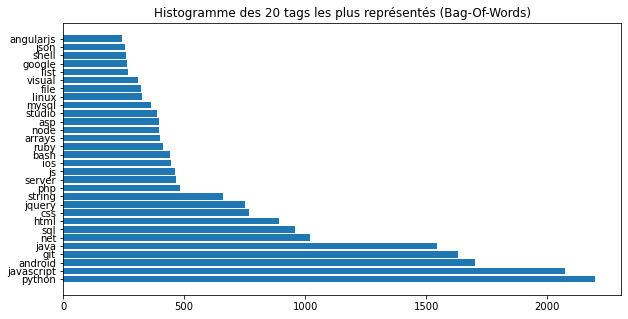

In [140]:
top_20_tags_word = df_tags.sort_values("Value", ascending=False)[:30]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_tags_word.index, width=top_20_tags_word.Value)
plt.title("Histogramme des 20 tags les plus représentés (Bag-Of-Words)")
plt.show()

In [49]:
tags_more_frequent = df_tags.loc[df_tags["Value"] >= 150].sort_values("Value", ascending=False).index.tolist()

In [50]:
tags_only = df["Tags1"].str.split(",", expand=True)
df = pd.merge(df, tags_only,left_index=True,right_index=True)
df.columns = ["Id", "Title", "Body", "Tags","CreationDate","Tags1" ,"Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"]

In [52]:
tags = ["Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"]

for i in tags_more_frequent:
    for j in tags:
        more_frequent = df.loc[df[j].str.contains(i, na=True)]
        
more_frequent.drop(["Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"], axis=1, inplace=True)

C:\Users\jerom\anaconda3\envs\PROJET5\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Deuxième méthode avec le TOKENIZER et l'expression régulière

In [86]:
#Expression régulière pour prendre uniquement les valeurs entre <>
tokenizer = RegexpTokenizer('(?<=\<).*?(?=\>)')

#Création de la colonne avec ces valeurs
df['tags_words'] = df.apply(lambda row: tokenizer.tokenize(row['Tags']), axis=1)

#Comptage de l'utlisation des mots
Top_Word = nltk.FreqDist()
Top100 = []
for x in df['tags_words']:
    Top_Word += nltk.FreqDist(x)

for i in Top_Word.most_common()[0:100]:
    Top100.append(i[0])

In [87]:
#Fonction qui supprime le tag si celui ci n'appartient au TOP        
def removeNotTop100(Word_list):
    filtered_Word_list = Word_list[:] #make a copy of the Word_list
    for Word in Word_list: # iterate over Word_list
        if Word not in Top100: 
            filtered_Word_list.remove(Word) # remove Word from filtered_Word_list if it is a stopword
    if len(filtered_Word_list) == 0:
        return None
    else:
        return filtered_Word_list

In [88]:
#Suppression des Tags qui ne sont pas dans le TOP
df['processed_tags_final'] = df.apply(lambda row:removeNotTop100(row['tags_words']), axis=1)

In [89]:
#Suppression des lignes sans Tags
df = df.dropna()

## Affichage d'un WORDCLOUD sur la feature TAGS

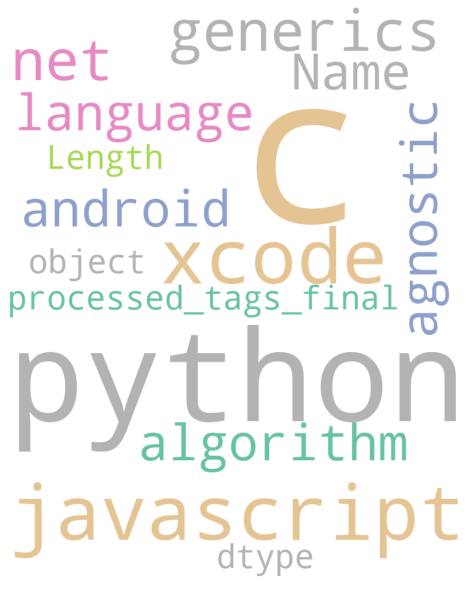

In [90]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_tags_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Préprocesing du champs BODY
* Utilisation de BEAUTIFULSOUP pour le traitement HTML
* Puis remplacement des retours chariots et des :
* Création du nuage de mots
* Supression des StopWord Anglais

In [91]:
#Préprocessing du champ BODY
df['processed_body'] = df['BODY'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
df['processed_body'] = df['processed_body'].map(lambda x: x.replace('\n', ' '))
df['processed_body'] = df['processed_body'].map(lambda x: x.replace(':', ''))

#Création des nuages de mots avec NLTK
df['processed_body2'] = df.apply(lambda row: nltk.word_tokenize(row['processed_body'],language='english'), axis=1)

#Supression des StopWord
df['processed_body_final'] = df.apply(lambda row:removeStopWord(row['processed_body2']), axis=1)

#Lemmatisation
df['processed_body_final'] = df.apply(lambda row:lemmatisation(row['processed_body_final']), axis=1)

## Fonction de preprocessing
* RemoveStopWord : Fonction pour supprimer les stopword Anglais
* lemmatisation : Fonction pour trouver la racine des mots

In [92]:
stop_words = set(stopwords.words('English'))
def removeStopWord(Word_list):
    filtered_Word_list = Word_list[:] #make a copy of the Word_list
    for Word in Word_list: # iterate over Word_list
        if Word.lower() in stop_words: 
            filtered_Word_list.remove(Word) # remove Word from filtered_Word_list if it is a stopword
    return filtered_Word_list

#Fonction de lemmatisation
def lemmatisation(Word_list):
    Words = Word_list[:] #make a copy of the Word_list
    Words = [lancaster.stem(word) for word in Words]
    return Words

### Création d'un nuage de mots pour le BODY

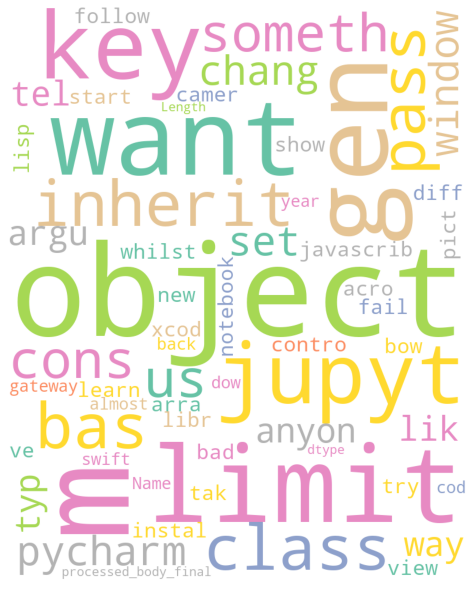

In [93]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_body_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Préprocesing du champs Titre

* Remplacement des retours chariots et des :
* Création du nuage de mots
* Supression des StopWord Anglais

In [94]:
#Préprocessing du champ Title
df['processed_title'] = df['Title'].map(lambda x: x.replace('\n', ' '))
df['processed_title'] = df['processed_title'].map(lambda x: x.replace(':', ''))

#Création des nuages de mots avec NLTK
df['processed_title2'] = df.apply(lambda row: nltk.word_tokenize(row['processed_title'],language='english'), axis=1)

#Supression des StopWord
df['processed_title_final'] = df.apply(lambda row:removeStopWord(row['processed_title2']), axis=1)

#Lemmatisation
df['processed_title_final'] = df.apply(lambda row:lemmatisation(row['processed_title2']), axis=1)

In [96]:
#Suppression des colonnes inutiles
df.drop({'processed_body','processed_body2','tags_words','processed_title','processed_title2'}, axis=1, inplace=True)

In [98]:
df.head(10)

,Id,BODY,Title,Tags,CreationDate,processed_tags_final,processed_body_final,processed_title_final
0,12051,<p>If I inherit from a base class and want to ...,Calling the base constructor in C#,<c#><.net><inheritance><constructor>,2008-08-15 07:39:23,"[c#, .net]","[inherit, bas, class, want, pass, someth, cons...","[cal, the, bas, construct, in, c, #]"
1,17319422,<p>I am using PyCharm on Windows and want to c...,How do I set the maximum line length in PyCharm?,<python><pycharm><pep8>,2013-06-26 12:00:31,[python],"[us, pycharm, window, want, chang, set, limit,...","[how, do, i, set, the, maxim, lin, leng, in, p..."
2,32664,<p>Can anyone tell me if there is a way with g...,Is there a constraint that restricts my generi...,<c#><generics><constraints>,2008-08-28 16:04:49,"[c#, generics]","[anyon, tel, way, gen, limit, gen, typ, argu, ...","[is, ther, a, constraint, that, restrict, my, ..."
3,8763125,<p>I would like to get the keys of a JavaScrip...,Get array of object's keys,<javascript><ecmascript-5>,2012-01-06 19:12:38,[javascript],"[would, lik, get, key, javascrib, object, arra...","[get, array, of, object, 's, key]"
5,33923,"<p>Whilst starting to learn lisp, I've come ac...",What is tail recursion?,<algorithm><language-agnostic><functional-prog...,2008-08-29 03:48:03,"[algorithm, language-agnostic]","[whilst, start, learn, lisp, ,, 've, com, acro...","[what, is, tail, recurs, ?]"
6,33969,<p>We're experimenting with various ways to th...,Best way to implement request throttling in AS...,<asp.net-mvc><throttling>,2008-08-29 04:50:50,[asp.net-mvc],"['re, expery, vary, way, throttle, us, act, gi...","[best, way, to, impl, request, throttling, in,..."
7,33978,<p>How would you go about finding out how much...,Find out how much memory is being used by an o...,<python><performance><memory-profiling>,2008-08-29 04:59:31,"[python, performance]","[would, go, find, much, mem, us, object, ?, kn...","[find, out, how, much, mem, is, being, us, by,..."
8,33207,<p>What frameworks exist to unit test Objectiv...,What is the best way to unit test Objective-C ...,<objective-c><cocoa><unit-testing><xcode>,2008-08-28 19:41:30,"[objective-c, unit-testing, xcode]","[framework, ex, unit, test, objective-c, cod, ...","[what, is, the, best, way, to, unit, test, obj..."
9,32899,<p>I have some kind of test data and want to c...,How do you generate dynamic (parameterized) un...,<python><unit-testing><parameterized-unit-test>,2008-08-28 17:49:02,"[python, unit-testing]","[kind, test, dat, want, cre, unit, test, item,...","[how, do, you, gen, dynam, (, paramet, ), unit..."
10,33746,<p>At work we are being asked to create XML fi...,XML attribute vs XML element,<xml><xsd>,2008-08-29 01:15:52,[xml],"[work, ask, cre, xml, fil, pass, dat, anoth, o...","[xml, attribut, vs, xml, el]"


In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

# Création du jeu de test et d'entrainement

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

In [ ]:
from sklearn.datasets import make_multilabel_classification
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score




mlp1 = MLPClassifier(hidden_layer_sizes=(200, ), max_iter=200, random_state=1)
mlp1.fit(df_train.loc[:,{'processed_title_final','processed_body_final'}].to_numpy(), df_train.loc[:,'processed_tags_final'].to_numpy())
y_pred1 = mlp1.predict(df_test.loc['processed_title_final','processed_body_final'].to_numpy())

#mlp2 = MLPClassifier(hidden_layer_sizes=(200, ), max_iter=200, random_state=1)
#mlp2.partial_fit(df_train.loc[:,{'processed_title_final','processed_body_final'}],df_train.loc[:,'processed_tags_final'], classes=list(range(df_train.loc[:,'processed_tags_final'].shape[1])))
#y_pred2 = mlp2.predict(x_test)

print('Using `fit`:')
print(accuracy_score(y_test, y_pred1))

#print('Using `partial_fit`:')
#print(accuracy_score(y_test, y_pred2))

In [ ]:
df_train.loc[:,'processed_tags_final'].shape[1]

In [ ]:
X, y = make_multilabel_classification(n_samples=1000, n_features=10,
                                      n_classes=5, n_labels=2,
                                      allow_unlabeled=False, random_state=1)

# Extraction des TOPICS avec NMF 

In [109]:
# Fonction qui ne fait rien pour exploiter le pré traitement que nous avons réalisé
def dummy(doc):
    return doc

## Première étape on vectorize avec TF-IDF

In [111]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000,tokenizer=dummy,
        preprocessor=dummy)
tfidf = tfidf_vectorizer.fit_transform(df["processed_title_final"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

## Puis on calcul les topics avec NMF

In [112]:
from sklearn.decomposition import NMF
k = 10
# create the model, specifiying the initialization strategy and the number of topics to produce
model = NMF(init="nndsvd", n_components=k) 
# apply the model and extract the two factor matrices
W = model.fit_transform(tfidf)
H = model.components_

In [114]:
W.shape

(15171, 10)

In [116]:
W[0,:].round(2)

array([0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.07, 0.  ])

In [117]:
H.shape

(10, 7171)

In [126]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( tfidf_feature_names[term_index] )
    return top_terms

In [128]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( tfidf_feature_names, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: to, how, ?, an, us, ad, with, way, convert, array
Topic 02: what, and, diff, between, is, the, ?, 's, ,, ar
Topic 03: i, do, how, ?, can, us, you, an, should, my
Topic 04: (, ), us, ,, vs, doe, not, why, funct, or
Topic 05: a, if, check, is, list, cre, ex, ther, funct, vary
Topic 06: '', ``, doe, not, er, ?, for, is, mean, us
Topic 07: of, the, get, list, an, valu, el, object, array, cur
Topic 08: git, fil, on, from, commit, branch, reposit, chang, remov, loc
Topic 09: in, python, javascrib, jav, c, #, stat, vary, sql, ?
Topic 10: string, convert, from, charact, array, remov, into, int, split, to


In [130]:
def plot_top_term_weights( tfidf_feature_names, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( tfidf_feature_names[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

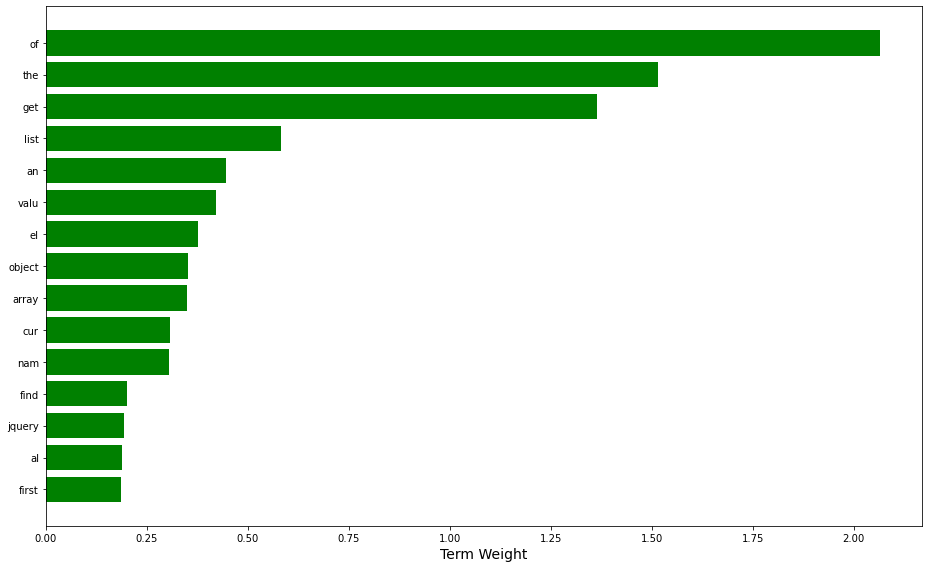

In [132]:
plot_top_term_weights(tfidf_feature_names, H, 6, 15)

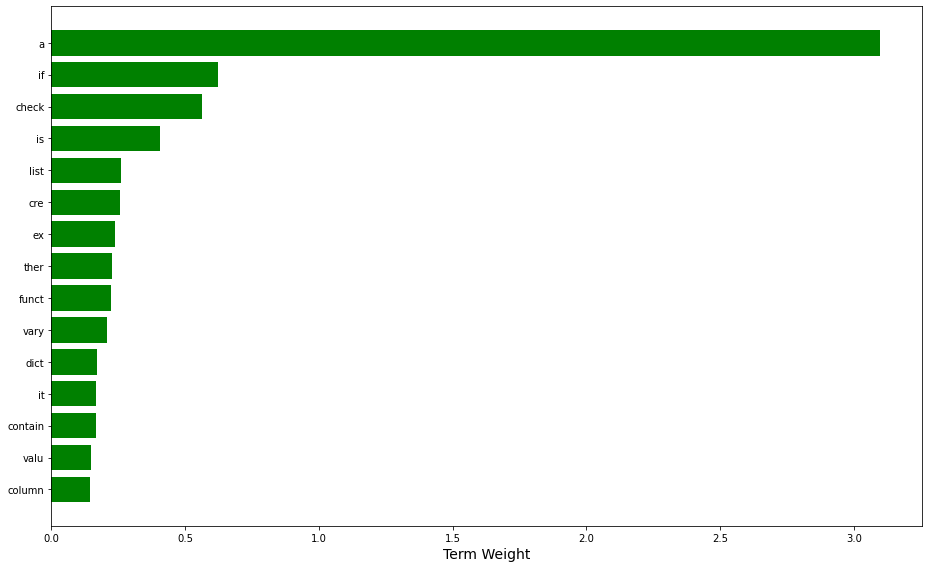

In [134]:
plot_top_term_weights(tfidf_feature_names, H, 4, 15)